<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Set-up-as-classification-problem" data-toc-modified-id="Set-up-as-classification-problem-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Set up as classification problem</a></span></li></ul></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train test split</a></span></li></ul></div>

In [1]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import scienceplots
import latex

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# Set plotting parameters
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')

# Read data
df_og = load(config['PATH']['DATA_DIR'] + '/full_df_agg_cap95.joblib')

c:\Users\caspa\Desktop\data-mining-techniques-vu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up as classification problem
For a classification problem we need a discrete target (multiple classes), as the target is average mood we need to transform the target.
We therefore round to the closest integer.


In [2]:
# Construct target as bad (0-6), okay (6-8), good (8-10)
df = df_og.copy()
df['target'] = df['target'].apply(lambda x: 0 if x < 7 else 1)
# df = pd.get_dummies(df, columns=['id'], prefix='id')
df = df.drop(columns=['id'], inplace=False)

# Impute outliers (larger than 1.5 IQR) with mean of column in all _sum columns
# for col in df.columns:
#     if col.endswith('_sum'):
#         df[col] = df[col].mask(df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)), df[col].mean())

## Train test split
As we are dealing with time series data we can't take a random 70/30 split of the data. 


[datetime.date(2014, 4, 17), datetime.date(2014, 4, 25)]

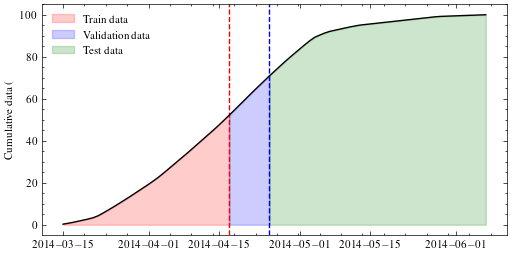

In [3]:
def find_split_ts(df, split_ratios, date_colname='time', plot_data=False, save_fig_name = None):
    split_points = np.cumsum(split_ratios) * 100
    dates = df[date_colname].unique()
    dates.sort()
    x = []
    y = []
    for date in dates:
        x.append(date)
        y.append(len(df[df[date_colname] <= date]) / len(df) * 100)



    split_dates = []
    for split in split_points:
        for i in range(len(x)):
            if y[i] >= split:
                split_dates.append(x[i])
                break
    
    c = ['red', 'blue', 'green']
    if plot_data:
        plt.figure(figsize=(6, 3))
        for i, (split, split_date) in enumerate(zip(split_points, split_dates)):
            plt.axvline(split_date, linestyle='--', color=c[i])
            # fill background
            if i == 0:
                plt.fill_between(x, y, where=np.logical_and(np.array(x) <= split_date, np.array(x) >= np.min(x)), color=c[i], alpha=0.2, label='Train data')
            else: 
                plt.fill_between(x, y, where=np.logical_and(np.array(x) <= split_date, np.array(x) >= split_dates[i-1]), color=c[i], alpha=0.2, label='Validation data')
        plt.fill_between(x, y, where=np.array(x) >= split_dates[-1], color=c[-1], alpha=0.2, label='Test data')
        plt.ylabel('Cumulative data (\%)')

        split_dates_str = [str(date)[:10] for date in split_dates]
        # split dates str to a single string
        split_dates_str = ', '.join(split_dates_str)
        # plt.title(f'Cumulative distribution of data. Splits at {split_dates_str}%')
        plt.legend()
        plt.plot(x, y)
        if save_fig_name is not None:
            plt.savefig('figures/' + save_fig_name + '.pdf')

    return split_dates

find_split_ts(df, [0.5, 0.2], plot_data = True, save_fig_name = 'data_splits')

# Classification algorithm 
We optimize over parameters but also over classification algorithm
Included algorithms are: 
* RandomForest
* GradientBoosting
* NaiveBayes
* SVC
* KNN


In [4]:
X, y = df.drop(columns=['target'], axis = 1), df['target']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_ts(X, y, split_ratios=[0.5, 0.2])

#TODO: Create buffer between test and validation data of the rolling window size (so that we don't use data from the future)


In [6]:
len(X_train)

566

In [6]:
import random
# Create the column transformer for standardization
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list(X_train.columns))
    ])

# Define the objective function for the optimization
def objective(trial: Trial):
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'GradientBoosting', "Naive Bayes", "SVC", "KNN"])

    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        classifier_obj = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    elif classifier_name == 'Naive Bayes':
        classifier_obj = GaussianNB()
    elif classifier_name == 'SVC':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        classifier_obj = SVC(C=C, kernel=kernel, decision_function_shape='ovr')
    else:  # KNN
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
        
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Optimize the pipeline using Optuna
manual_seed = 42
np.random.seed(manual_seed)
random.seed(manual_seed)
sampler = TPESampler(seed=manual_seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=30)

# Print the best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.number}, Accuracy: {best_trial.value}")
print(f"Best params: {best_trial.params}")



[I 2023-04-19 15:41:47,712] A new study created in memory with name: no-name-3fce45c4-05de-4120-9b57-e89670bca3f4
[I 2023-04-19 15:41:48,577] Trial 0 finished with value: 0.6338028169014085 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 39, 'learning_rate': 0.06750277604651747, 'max_depth': 9}. Best is trial 0 with value: 0.6338028169014085.
[I 2023-04-19 15:41:48,624] Trial 1 finished with value: 0.5821596244131455 and parameters: {'classifier': 'SVC', 'C': 0.018794668241638456, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.6338028169014085.
[I 2023-04-19 15:41:48,640] Trial 2 finished with value: 0.5586854460093896 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 0 with value: 0.6338028169014085.
[I 2023-04-19 15:41:48,654] Trial 3 finished with value: 0.5586854460093896 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 0 with value: 0.6338028169014085.
[I 2023-04-19 15:41:48,674] Trial 4 finished with value: 0.5586854460093896 and par

Best trial: 22, Accuracy: 0.7136150234741784
Best params: {'classifier': 'RandomForest', 'n_estimators': 43, 'max_depth': 4}


In [7]:
best_pipe = get_best_pipeline(best_trial, X_train)
best_pipe.fit(X_train, y_train)
pred = best_pipe.predict(X_test)
accuracy_score(y_test, pred)

0.7254901960784313

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

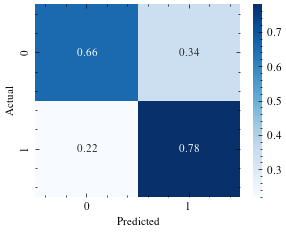

In [11]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('figures/rf_confusion_matrix.pdf')
plt.show()



In [9]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       157
           1       0.74      0.78      0.76       200

    accuracy                           0.73       357
   macro avg       0.72      0.72      0.72       357
weighted avg       0.72      0.73      0.72       357

